# Example with flow in a channel with a bump

This is a test case with particles released in a simple looping flow field
The depth profile is given by: 

$d(x) = d_m - d_b * bump(x,l_b)$

Where:
- $d_m$ is the mean depth
- $d_b$ is the height of the bump
- $l_b$ is the length of the bump
- $L$ is half the length of the channel
- $u_m$ is the mean flow 

The domain is $x \in [-L,L], y \in [-d_m,0]$


In [2]:
# Load required libraries
using Pkg
Pkg.precompile() # command needed after modifying the src code
Pkg.activate("..")
using Particles
using Plots, LaTeXStrings
using Random

#rng_recursion = MersenneTwister(1234) 

nothing

Precompiling project...

  ✓ Glob


  ✓ WorkerUtilities
  ✓ SoftGlobalScope
  ✓ WoodburyMatrices


  ✓ AbstractFFTs
  ✓ IterTools


  ✓ TextWrap


  ✓ PropertyDicts
  ✓ IniFile
  ✓ VersionParsing


  ✓ Compat


  ✓ URIs
  ✓ URIParser


  ✓ Retry


  ✓ LittleEndianBase128
  ✓ Ratios


  ✓ SymDict


  ✓ DiskArrays


  ✓ InvertedIndices


  ✓ SentinelArrays
  ✓ CFTime
  ✓ MappedArrays


  ✓ GZip


  ✓ ZipFile


  ✓ PooledArrays


  ✓ StringManipulation
  ✓ OpenSSL_jll


  ✓ Kaleido_jll
  ✓ Crayons


  ✓ Lz4_jll


  ✓ libsodium_jll


  ✓ InlineStrings


  ✓ StackViews


  ✓ Libtiff_jll
  ✓ PaddedViews


  ✓ EzXML


  ✓ AxisAlgorithms


  ✓ FileIO


  ✓ ArgParse


  ✓ Compat → CompatLinearAlgebraExt


  ✓ AbstractFFTs → AbstractFFTsTestExt


  ✗ Conda


  ✓ LazyJSON


  ✓ Mocking


  ✓ FilePathsBase


  ✓ Ratios → RatiosFixedPointNumbersExt


  ✓ RawArray


  ✓ BinDeps


  ✓ ChainRulesCore


  ✓ HTTP


  ✓ Qt5Base_jll
  ✓ FFMPEG_jll


  ✓ WeakRefStrings


  ✓ DataStructures


  ✓ HDF5_jll


  ✓ ZeroMQ_jll


  ✗ PyCall


  ✓ ImageMagick_jll
  ✓ Blosc_jll


  ✓ XMLDict
  ✓ LogExpFunctions → LogExpFunctionsChainRulesCoreExt


  ✓ AbstractFFTs → AbstractFFTsChainRulesCoreExt


  ✓ Unitful


  ✓ Interpolations


  ✓ SortingAlgorithms


  ✓ PrettyTables


  ✓ FFMPEG


  ✓ WebSockets


  ✗ PyPlot


  ✓ SpecialFunctions


  ✓ MosaicViews


  ✓ UnitfulLatexify


  ✓ ZMQ


  ✓ StatsBase


  ✓ WebIO


  ✓ DiffRules


  ✓ Blosc


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ JSExpr


  ✓ Mux


  ✓ NetCDF_jll


  ✓ SpecialFunctions → SpecialFunctionsChainRulesCoreExt


  ✗ IJulia


  ✓ ColorSchemes


  ✓ ForwardDiff


  ✓ NetCDF


  ✓ AWSCore


  ✓ Blink


  ✓ PlotlyBase


  ✓ 

ForwardDiff → ForwardDiffStaticArraysExt


  ✓ 

GR_jll


  ✓ 

PreallocationTools

  ✓ PlotUtils


  ✓ GR


  ✓ PlotlyJS


  ✓ LabelledArrays


  ✓ PlotThemes


  ✓ CSV


  ✓ RecipesPipeline


  ✓ Plotly


  ✓ ImageCore


  ✓ AWSSDK


  ✓ Zarr


  ✓ ImageMagick


  ✓ DataFrames


  ✓ Latexify → DataFramesExt


  ✓ Plots


  ✓ Plots → FileIOExt


  ✗ Plots → IJuliaExt


  ✓ Plots → UnitfulExt


  ✓ Particles
  106 dependencies successfully precompiled in 448 seconds. 139 already precompiled.



Pkg.Types.PkgError: The following 2 direct dependencies failed to precompile:

PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]

Failed to precompile PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee] to "C:\\Users\\hugo1\\.julia\\compiled\\v1.9\\PyPlot\\jl_B269.tmp".
[91m[1mERROR: [22m[39mLoadError: Conda is not properly configured.  Run Pkg.build("Conda") before importing the Conda module.
Stacktrace:
 [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
[90m   @[39m [90mBase[39m [90m.\[39m[90m[4merror.jl:35[24m[39m
 [2] top-level scope
[90m   @[39m [90mC:\Users\hugo1\.julia\packages\Conda\2lg2O\src\[39m[90m[4mConda.jl:26[24m[39m
 [3] [0m[1minclude[22m
[90m   @[39m [90m.\[39m[90m[4mBase.jl:457[24m[39m[90m [inlined][39m
 [4] [0m[1minclude_package_for_output[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90minput[39m::[0mString, [90mdepot_path[39m::[0mVector[90m{String}[39m, [90mdl_load_path[39m::[0mVector[90m{String}[39m, [90mload_path[39m::[0mVector[90m{String}[39m, [90mconcrete_deps[39m::[0mVector[90m{Pair{Base.PkgId, UInt128}}[39m, [90msource[39m::[0mString[0m[1m)[22m
[90m   @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2049[24m[39m
 [5] top-level scope
[90m   @[39m [90m[4mstdin:3[24m[39m
in expression starting at C:\Users\hugo1\.julia\packages\Conda\2lg2O\src\Conda.jl:1
in expression starting at stdin:3
[91m[1mERROR: [22m[39mLoadError: Failed to precompile Conda [8f4d0f93-b110-5947-807f-2305c1781a2d] to "C:\\Users\\hugo1\\.julia\\compiled\\v1.9\\Conda\\jl_B42A.tmp".
Stacktrace:
  [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4merror.jl:35[24m[39m
  [2] [0m[1mcompilecache[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90mpath[39m::[0mString, [90minternal_stderr[39m::[0mIO, [90minternal_stdout[39m::[0mIO, [90mkeep_loaded_modules[39m::[0mBool[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2300[24m[39m
  [3] [0m[1mcompilecache[22m
[90m    @[39m [90m.\[39m[90m[4mloading.jl:2167[24m[39m[90m [inlined][39m
  [4] [0m[1m_require[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90menv[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1805[24m[39m
  [5] [0m[1m_require_prelocked[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId, [90menv[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1660[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @[39m [90m.\[39m[90m[4mloading.jl:1648[24m[39m[90m [inlined][39m
  [7] [0m[1mmacro expansion[22m
[90m    @[39m [90m.\[39m[90m[4mlock.jl:267[24m[39m[90m [inlined][39m
  [8] [0m[1mrequire[22m[0m[1m([22m[90minto[39m::[0mModule, [90mmod[39m::[0mSymbol[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1611[24m[39m
  [9] [0m[1minclude[22m
[90m    @[39m [90m.\[39m[90m[4mBase.jl:457[24m[39m[90m [inlined][39m
 [10] [0m[1minclude_package_for_output[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90minput[39m::[0mString, [90mdepot_path[39m::[0mVector[90m{String}[39m, [90mdl_load_path[39m::[0mVector[90m{String}[39m, [90mload_path[39m::[0mVector[90m{String}[39m, [90mconcrete_deps[39m::[0mVector[90m{Pair{Base.PkgId, UInt128}}[39m, [90msource[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2049[24m[39m
 [11] top-level scope
[90m    @[39m [90m[4mstdin:3[24m[39m
in expression starting at C:\Users\hugo1\.julia\packages\PyCall\ilqDX\src\PyCall.jl:1
in expression starting at stdin:3
[91m[1mERROR: [22m[39mLoadError: Failed to precompile PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0] to "C:\\Users\\hugo1\\.julia\\compiled\\v1.9\\PyCall\\jl_B246.tmp".
Stacktrace:
  [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4merror.jl:35[24m[39m
  [2] [0m[1mcompilecache[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90mpath[39m::[0mString, [90minternal_stderr[39m::[0mIO, [90minternal_stdout[39m::[0mIO, [90mkeep_loaded_modules[39m::[0mBool[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2300[24m[39m
  [3] [0m[1mcompilecache[22m
[90m    @[39m [90m.\[39m[90m[4mloading.jl:2167[24m[39m[90m [inlined][39m
  [4] [0m[1m_require[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90menv[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1805[24m[39m
  [5] [0m[1m_require_prelocked[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId, [90menv[39m::[0mString[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1660[24m[39m
  [6] [0m[1mmacro expansion[22m
[90m    @[39m [90m.\[39m[90m[4mloading.jl:1648[24m[39m[90m [inlined][39m
  [7] [0m[1mmacro expansion[22m
[90m    @[39m [90m.\[39m[90m[4mlock.jl:267[24m[39m[90m [inlined][39m
  [8] [0m[1mrequire[22m[0m[1m([22m[90minto[39m::[0mModule, [90mmod[39m::[0mSymbol[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:1611[24m[39m
  [9] [0m[1minclude[22m
[90m    @[39m [90m.\[39m[90m[4mBase.jl:457[24m[39m[90m [inlined][39m
 [10] [0m[1minclude_package_for_output[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90minput[39m::[0mString, [90mdepot_path[39m::[0mVector[90m{String}[39m, [90mdl_load_path[39m::[0mVector[90m{String}[39m, [90mload_path[39m::[0mVector[90m{String}[39m, [90mconcrete_deps[39m::[0mVector[90m{Pair{Base.PkgId, UInt128}}[39m, [90msource[39m::[0mNothing[0m[1m)[22m
[90m    @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2049[24m[39m
 [11] top-level scope
[90m    @[39m [90m[4mstdin:3[24m[39m
in expression starting at C:\Users\hugo1\.julia\packages\PyPlot\H01LC\src\PyPlot.jl:2
in expression starting at stdin:3

IJulia [7073ff75-c697-5162-941a-fcdaad2a7d2a]

Failed to precompile IJulia [7073ff75-c697-5162-941a-fcdaad2a7d2a] to "C:\\Users\\hugo1\\.julia\\compiled\\v1.9\\IJulia\\jl_F534.tmp".
[91m[1mERROR: [22m[39mLoadError: IJulia not properly installed. Please run Pkg.build("IJulia")
Stacktrace:
 [1] [0m[1merror[22m[0m[1m([22m[90ms[39m::[0mString[0m[1m)[22m
[90m   @[39m [90mBase[39m [90m.\[39m[90m[4merror.jl:35[24m[39m
 [2] top-level scope
[90m   @[39m [90mC:\Users\hugo1\.julia\packages\IJulia\Vo51o\src\[39m[90m[4mIJulia.jl:49[24m[39m
 [3] [0m[1minclude[22m
[90m   @[39m [90m.\[39m[90m[4mBase.jl:457[24m[39m[90m [inlined][39m
 [4] [0m[1minclude_package_for_output[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId, [90minput[39m::[0mString, [90mdepot_path[39m::[0mVector[90m{String}[39m, [90mdl_load_path[39m::[0mVector[90m{String}[39m, [90mload_path[39m::[0mVector[90m{String}[39m, [90mconcrete_deps[39m::[0mVector[90m{Pair{Base.PkgId, UInt128}}[39m, [90msource[39m::[0mNothing[0m[1m)[22m
[90m   @[39m [90mBase[39m [90m.\[39m[90m[4mloading.jl:2049[24m[39m
 [5] top-level scope
[90m   @[39m [90m[4mstdin:3[24m[39m
in expression starting at C:\Users\hugo1\.julia\packages\IJulia\Vo51o\src\IJulia.jl:1
in expression starting at stdin:3


In [24]:
# Randompool setup and restart
randpool = MersenneTwister(123) #Generate same random numbers every time

# Load default settings 
# collected configuration is in Dict d
d = default_userdata() # start with some defaults
d["rng"] = randpool


MersenneTwister(123)

In [25]:

# settings for this experiment
n = 1 # number of particles
d["nparticles"] = n
# problem specific settings
d_b = 4.0
d["d_b"] = d_b # height of the bump [m]
l_b=300.0
d["l_b"] = l_b# length of the bump [m]
d_m=10.0
d["d_m"] = d_m # mean depth [m]
u_m=1.0
d["u_m"] = u_m # mean flow [m/s]
L=500.0
d["L"] = 500.0 # half the length of the channel [m]
# all variables for one particle are collected in a vector
variables = ["x", "y", "z", "age"]
d["variables"] = variables
# initial position of the particles
m = length(variables)
p = zeros(m, n)
p[1, :] = (-0.9*L) .+ 0.01 .* L .* randn(randpool, n, 1) # particles are spawned close to the left boundary
p[3, :] = (-d_m) .+ 1.0 .* d_m .* rand(randpool, n, 1)
d["particles"] = p # initial values
# simulation time
d["dt"] = 1.0     #time-step
d["tstart"] = 0.0 
d["tend"] = 20.0 #800
tend=d["tend"]
# write to netcdf
d["write_maps_times"] = collect(0.0:10.0:tend)
d["write_maps"] = false #do not write to netcdf
d["write_maps_filename"] = "output_loop.nc"
# write plots to file
d["plot_maps_times"] = collect(0.0:10.0:tend)
d["plot_maps"] = false # do not make png figures
d["plot_maps_size"]=(900,300)
d["plot_maps_func"] = plot_maps_xz

# keep some output in memory
d["keep_particles"] = true #keep results in memory (bad idea for a large run)
d["keep_particle_times"] = collect(0.0:10.0:tend)

nothing



Two test cases are embedded.
The first test case tests the algorithm that divides the timestep by half, takes a new random number and thus weakens the strength of diffusion strength and "controlls" the direction of turbulent velocity. To test the algorithm, we only add one particle into the computation domain and set the keyword parameter `d["is_cross_bc"] = false` and `d["is_apply_cross_bc_test"] = true`.

In [26]:
# the following options are to be added in the default_userdata() function
# if to apply the algorithm to prevent the algorithm from crossing the boundary or not
d["is_cross_bc"] = false
d["is_apply_cross_bc_test"] = true # if applied, only one particle is used and all virtual trajectories are also recorded
if d["is_apply_cross_bc_test"]
    d["the_virtual_trajectory"] = d["particles"]
end
d["is_keep_these_particles"] = trues(d["nparticles"],)
d["recursion_depth"] = 10

# to be added according to the actual problem
d["is_particle_in_domain"] = x -> nothing

# magnitude of the diffusion profile
K_MAG = 2.5
# set figname
figname="pcb.svg"

"pcb.svg"

In [27]:
# if initialize particle location to perform the single particle test

#p = [-452.01034034514936,0.0,-8.633525058830664,0.0] # will end up hitting the lower boundary
#p = [-452.01034034514936,0.0,-1.833525058830664,0.0]
p = [-200.01034034514936,0.0,-8.53525058830664,0.0] # will end up hitting the lower boundary

d["particles"] = reshape(p, length(p), 1)

4×1 Matrix{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [28]:
d #show configuration

Dict{String, Any} with 36 entries:
  "plot_maps_prefix"       => "map"
  "write_maps"             => false
  "reftime"                => DateTime("2000-01-01T00:00:00")
  "particles"              => [-200.01; 0.0; -8.53525; 0.0;;]
  "nparticles"             => 1
  "is_apply_cross_bc_test" => true
  "plot_maps_times"        => [0.0, 10.0, 20.0]
  "dt"                     => 1.0
  "tend"                   => 20.0
  "write_maps_dir"         => "."
  "write_maps_filename"    => "output_loop.nc"
  "L"                      => 500.0
  "d_m"                    => 10.0
  "is_particle_in_domain"  => #11
  "variables"              => ["x", "y", "z", "age"]
  "keep_particle_times"    => [0.0, 10.0, 20.0]
  "dumval"                 => 9999.0
  "write_maps_as_series"   => true
  "keep_particles"         => true
  ⋮                        => ⋮

In [29]:
p

4-element Vector{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [30]:
d["particles"]

4×1 Matrix{Float64}:
 -200.01034034514936
    0.0
   -8.53525058830664
    0.0

In [31]:
# Define the flow field

# bump function
function bump(x, l_b)
    if abs(x) < l_b
        return 0.5 * (1.0 + cos(pi * x / l_b))
    else
        return 0.0
    end
end

function derivative_bump(x, l_b)
    if abs(x) < l_b
        return -0.5 * pi / l_b * sin(pi * x / l_b)
    else
        return 0.0
    end
end

# depth profile
function depth(x, d_m, d_b, l_b)
    d_m - d_b * bump(x, l_b)
end


# derivative of depth profile
function derivative_depth(x, d_m, d_b, l_b)
    -d_b * derivative_bump(x, l_b)
end

# Stream function with value 0 at the surface and u_m * d_m at the bottom
# Note that the depth is variable
function stream(x, y, z, t)
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return -u_m * d_m
    else
        return -u_m * d_m * z / d_x
    end
end

# flow in x direction (for now has to be called u)
function u(x, y, z, t)
    # u=-s_z
    d_m = d["d_m"]
    d_b = d["d_b"]
    l_b = d["l_b"]
    u_m = d["u_m"]
    d_x = depth(x, d_m, d_b, l_b) # depth at x
    if z>0.0
        return 0.0
    elseif z<-d_x
        return 0.0
    else
        return u_m * d_m / d_x
    end
end


# flow in y direction (for now has to be called v)
function v(x, y, z, t)
    return 0.0
end

# flow in y direction (for now has to be called w)
function w(x, y, z, t)
   # w=s_x
   d_m = d["d_m"]
   d_b = d["d_b"]
   l_b = d["l_b"]
   u_m = d["u_m"]
   d_x = depth(x, d_m, d_b, l_b) # depth at x
   if z>0.0
       return 0.0
   elseif z<-d_x
       return 0.0
   else
       return u_m * d_m * z / d_x^2 * derivative_depth(x, d_m, d_b, l_b)
   end
end

nothing

In [32]:
# implement that function that identifies whether the particle is currently
# inside the particle or not
function is_particle_in_domain(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir
end
d["is_particle_in_domain"] = is_particle_in_domain

is_particle_in_domain (generic function with 1 method)

In [33]:
# add diffusion profile
function parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return 6 * z  * (1-z) * K_MAG
    else
        return 0
    end
end

# add diffusion profile
function derivative_parabola_diffusion(z)
    H = 1 # unit length water column
    if z<=H && z>=0
        return (6 - 12 *z) * K_MAG
    else 
        return 0
    end
end

function double_parabola_diffusion(z,a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude* c *z*(H-2*z)^(1/a)
    else
        return magnitude* c *(H-z)*(2*z-1)^(1/a)
    end
end

function derivative_double_parabola_diffusion(z, a=1, magnitude=1.0)
    # input with reference coordinate z, shape parameter a and magnitude z
    H = 1 # unit length water column
    c = 2*(1+a)*(1+2*a)/(a*a*H^(1+1/a))
    if z>=0 && z<=H/2
        return magnitude*c*( z/a*(H-2*z)^(1/a-1)*(-2) + (H-2*z)^(1/a) )
    else
        return magnitude*c*( (H-z)/a*(2*z-1)^(1/a-1)*(2) + (-1)*(2*z-1)^(1/a)  ) 
    end
end

## keep g unchanged
 

## compute local coordinates

## dW



derivative_double_parabola_diffusion (generic function with 3 methods)

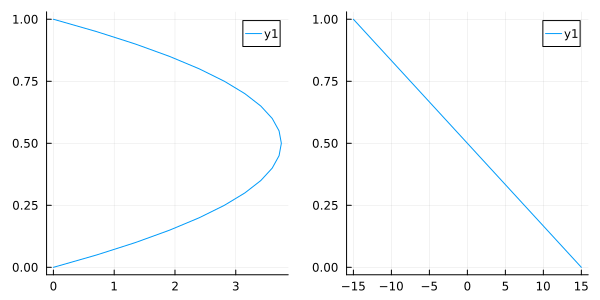

In [34]:
# plot the diffusion function
z = 0:0.05:1.0
K = similar(z)
dKdz = similar(z)
for i in 1:length(z)
    K[i] = parabola_diffusion(z[i])
    dKdz[i] = derivative_parabola_diffusion(z[i])
end
l = @layout([a b]);
p1 = plot(K,z)
p2 = plot(dKdz, z)
plot(p1,p2,size=(600,300),layout=l)


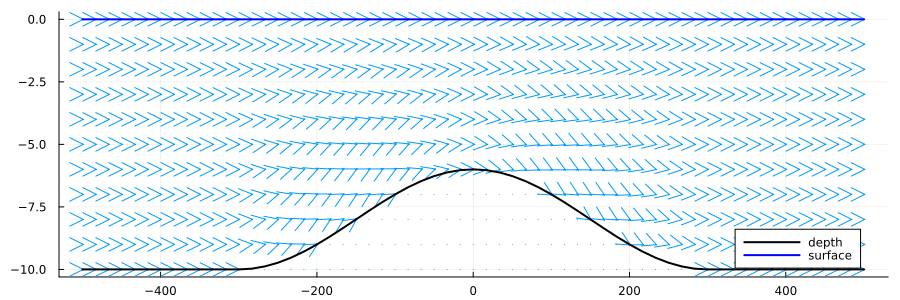

In [35]:
#plot flow field

#grid for plotting
d_m=d["d_m"];L=d["L"];u_m=d["u_m"]
xgrid=-L:(L/30):L
zgrid=-d_m:(d_m/10):0.0
nx=length(xgrid)
nz=length(zgrid)
xs=repeat(xgrid,1,nz)
zs=repeat(zgrid,1,nx)'

Plots.default(:size, d["plot_maps_size"])
scale_u=1.0
scale_w=1.0

#heatmap(xgrid,zgrid,w.(xs,0.0,zs,0.0)')
quiver(vec(xs),vec(zs),quiver=(scale_u*u.(vec(xs),0.0,vec(zs),0.0),scale_w*w.(vec(xs),0.0,vec(zs),0.0)),
    arrowscale=0.6, headsize=0.1)
plot!(xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")

In [36]:
# Here is the equation that we want to solve for the particles

"""
   !f(ds,s,t,i,d)

Dynamic model, computes time derivative ds of s at current time t
for particle i and possibly using data/functions from d of type userdata.
"""
function f!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = u(x, y, z, t)
   # dy/dt=v
   ∂s.y = v(x, y, z, t)
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   z_nd = (z+depth_z)/depth_z 
   #z_nd = (z+d_m)/d_m #d_m is the depth of the computation domain
   if z_nd<=1 && z_nd>=0
      ∂s.z = w(x,y,z,t) + derivative_parabola_diffusion(z_nd) 
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 1.0
end

"""
   !g(ds,s,t,i,d)

   Dynamic model, computes as ds the function g in the equation ds=f(s,t)dt+g(s,t)dw 
   for s at current time t for particle i and possibly using data/functions from d of type userdata.
"""
function g!(∂s, s, t, i, d)
   x, y, z, age = s
   # dx/dt=u
   ∂s.x = 0.0
   # dy/dt=v
   ∂s.y = 0.0
   # dz/dt=0
   depth_z = depth(x, d_m, d_b, l_b)
   z_nd = (z+depth_z)/depth_z 
   #z_nd = (z+d_m)/d_m 
   if z_nd<=1 && z_nd>=0
      ∂s.z = sqrt(2 * parabola_diffusion(z_nd))
   else
      ∂s.z = 0
   end
   # age=(t-t0)
   ∂s.t = 0.0
end
d["f"] = f!
d["g"] = g!


g! (generic function with 1 method)

In [37]:
# use streamfunction as background for plotting

function plot_background(d)
    L = d["L"]
    # streamfunction for plot
     x1 = -L:(L/100):L
     z1 = -d_m:(d_m/100):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], 0.0, z1[j], 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false)
     return(f)
 end
 d["plot_maps_background"] = plot_background
 

plot_background (generic function with 1 method)

In [38]:
run_simulation(d)

writing output to memory at t = 

[0.0, 10.0, 20.0]
interrupt simulation for output at t = [0.0, 10.0, 20.0]


Simulation from time 0.0s to 20.0s since 2000-01-01T00:00:00
t=0.0 -> 0.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:00 : 0.0%


simulate! runs for once.
t=0.0 -> 10.0  : 2000-01-01T00:00:00 -> 2000-01-01T00:00:10 : 50.0%


simulate! runs for once.
t=10.0 -> 20.0  : 2000-01-01T00:00:10 -> 2000-01-01T00:00:20 : 100.0%
simulate! runs for once.


In [39]:
fig2 = d["plot_maps_background"](d)
savefig(fig2, ".//result//stream_function_bump.png")


"j:\\Master_Thesis\\particles.jl\\example_notebooks\\result\\stream_function_bump.png"

In [41]:
d["all_particles"]

3-element Vector{Any}:
 [-200.01034034514936; 0.0; -8.53525058830664; 0.0;;]
 [-188.77884127445586; 0.0; -6.038020935060333; 10.0;;]
 [-177.26612896669087; 0.0; -3.9388206685337783; 20.0;;]

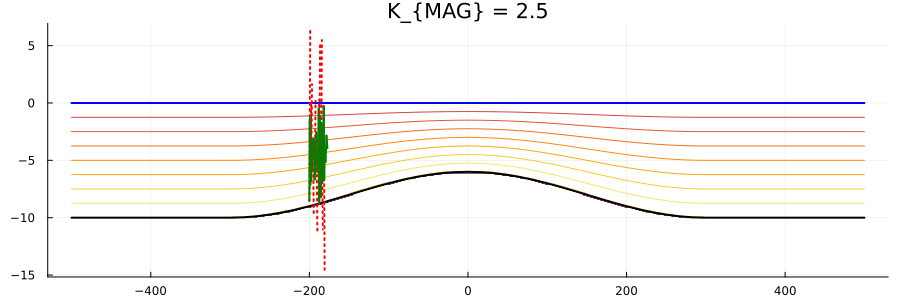

"j:\\Master_Thesis\\particles.jl\\example_notebooks\\result\\pcb.svg"

In [42]:
function is_inside(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir
end
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["the_virtual_trajectory"]
p = t[:, 1]
for i=2:size(t)[2]
    if is_inside(t[:,i])
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=2)
        p = t[:, i] # only update the particle location if it stays inside the domain
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:red, lw=2, ls=:dot)
    end
end
title!(fig, "K_{MAG} = $(K_MAG)")
display(fig)
savefig(fig, ".//result//"*figname)

In [43]:
d["all_particles"]

3-element Vector{Any}:
 [-200.01034034514936; 0.0; -8.53525058830664; 0.0;;]
 [-188.77884127445586; 0.0; -6.038020935060333; 10.0;;]
 [-177.26612896669087; 0.0; -3.9388206685337783; 20.0;;]

In [46]:
d["the_virtual_trajectory"]

4×43 Matrix{Float64}:
 -200.01     -198.899    -199.455    …  -179.592   -178.431    -177.266
    0.0         0.0         0.0            0.0        0.0         0.0
   -8.53525     6.31935    -1.40675       -5.1479    -2.84818    -3.93882
    0.0         1.0         0.5           18.0       19.0        20.0

In [45]:
"""
function is_inside(p)
    x,_,z,_ = p
    is_inside_xdir = x>-500 && x<500
    is_inside_zdir = (z<=0) && (z+depth(x, d_m, d_b, l_b)>=0) 
    return is_inside_xdir && is_inside_zdir
end
fig = d["plot_maps_background"](d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["all_particles"]
p = t[1] # Take the trajectory of the first particle out.
for i=2:length(t)
    if is_inside(t[i])
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:green, lw=2)
        p = t[i]
        #plot!(label="particle trajectory", legend=:best)
    else
        plot!(fig,[p[1],t[i][1]],[p[3],t[i][3]], color=:red, lw=2, ls=:dash)
    end
end
display(fig)
"""

"""
# use streamfunction as background for plotting

function plot_background_user(d)
    L = d["L"]
    L = 210
    # streamfunction for plot
     x1 = -L:(L/100):L
     z1 = -d_m:(d_m/100):0.0
     flow = zeros(length(x1), length(z1))
     for i = 1:length(x1)
         for j = 1:length(z1)
             flow[i,j] = stream(x1[i], 0.0, z1[j], 0.0)
         end
     end
     f = contour(x1, z1, flow', legend=false, size=(1200,400))
     return(f)
 end

fig = plot()
xgrid = -210:(210/100):210
zgrid = -d_m:(d_m/100):0.0
fig = plot_background_user(d)
d_b=d["d_b"];l_b=d["l_b"];d_m=d["d_m"]
plot!(fig,xgrid,-depth.(xgrid,d_m,d_b,l_b),lw=2.0,lc=:black,label="depth")
plot!(fig,xgrid,0.0*xgrid,lw=2.0,lc=:blue,label="surface")
t = d["the_virtual_trajectory"]
p = t[:, 1]
for i=2:size(t)[2]
    if is_inside(t[:, i])
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:green, lw=1)
        #plot!(label="particle trajectory", legend=:best)
        p = t[:, i] # only update the particle location if it stays inside the domain
    else
        plot!(fig,[p[1],t[1,i]],[p[3],t[3,i]], color=:red, lw=2, ls=:dot)
    end
end
title!(fig, "K_{MAG} = $(K_MAG)")
display(fig)
savefig(fig, ".//result//particle_hit_ground.svg")
"""
nothing

Core.nothing